# 一、已知多变量对连续单变量的预测

**目标变量**：Temperature (C)（温度）
**输入特征**：所有其他特征，包括日期、分类变量和数值变量。

## 1. 线性回归模型

In [1]:
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假设数据保存在 'weatherHistory.csv' 文件中
data = pd.read_csv('weatherHistory.csv')


# 将 'Formatted Date' 转换为日期时间格式
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

# 提取时间特征
data['Year'] = data['Formatted Date'].dt.year
data['Month'] = data['Formatted Date'].dt.month
data['Day'] = data['Formatted Date'].dt.day
data['Hour'] = data['Formatted Date'].dt.hour
data['Weekday'] = data['Formatted Date'].dt.weekday


# 对 'Summary' 和 'Precip Type' 进行独热编码
data = pd.get_dummies(data, columns=['Summary', 'Precip Type'], prefix=['Summary', 'PrecipType'])

# 删除原始的 'Formatted Date' 和 'Daily Summary' 列
data = data.drop(['Formatted Date', 'Daily Summary'], axis=1)

# 再次查看数据的信息
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96429 entries, 0 to 96428
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Temperature (C)                              96429 non-null  float64
 1   Apparent Temperature (C)                     96429 non-null  float64
 2   Humidity                                     96429 non-null  float64
 3   Wind Speed (km/h)                            96429 non-null  float64
 4   Wind Bearing (degrees)                       96429 non-null  float64
 5   Visibility (km)                              96429 non-null  float64
 6   Pressure (millibars)                         96429 non-null  float64
 7   Year                                         96429 non-null  int32  
 8   Month                                        96429 non-null  int32  
 9   Day                                          96429 non-null  int32  
 10

In [2]:
# 定义目标变量 y
y = data['Temperature (C)']

# 删除目标变量，剩下的都是特征
X = data.drop('Temperature (C)', axis=1)


# 将数据集划分为训练集和测试集，比例为 80%:20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 初始化标准化器
scaler = StandardScaler()

# 识别需要缩放的数值型特征（排除独热编码的特征）
numeric_features = ['Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
                    'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
                    'Year', 'Month', 'Day', 'Hour', 'Weekday']

# 对训练集进行拟合和转换
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# 对测试集进行转换
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 初始化线性回归模型
lr_model = LinearRegression()

# 训练模型
lr_model.fit(X_train, y_train)

# 对测试集进行预测
y_pred_lr = lr_model.predict(X_test)

# 定义评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} 模型评估结果：')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R² Score: {r2:.4f}\n')

# 评估线性回归模型
evaluate_model(y_test, y_pred_lr, '线性回归')


# 获取特征名称
feature_names = X_train.columns

# 获取模型系数
coefficients = lr_model.coef_

# 创建系数数据框
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# 按系数大小排序
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# 输出系数数据框
print(coeff_df)



线性回归 模型评估结果：
MSE: 0.8961
RMSE: 0.9466
MAE: 0.7406
R² Score: 0.9902

                                        Feature   Coefficient
0                      Apparent Temperature (C)  9.338752e+00
13                     Summary_Breezy and Foggy  1.927948e+00
21                Summary_Dry and Mostly Cloudy  1.083557e+00
20                                  Summary_Dry  1.021075e+00
22                Summary_Dry and Partly Cloudy  8.539982e-01
25                   Summary_Humid and Overcast  6.520252e-01
2                             Wind Speed (km/h)  5.899799e-01
24              Summary_Humid and Mostly Cloudy  4.957599e-01
11                               Summary_Breezy  4.786590e-01
26              Summary_Humid and Partly Cloudy  4.158095e-01
30                        Summary_Partly Cloudy  1.692247e-01
17                                Summary_Clear  1.301108e-01
29                             Summary_Overcast  1.236184e-01
28                        Summary_Mostly Cloudy  5.245805e-02
36

### 1.1 模型性能指标

- 均方误差 (MSE): 0.8961
- 均方根误差 (RMSE): 0.9466
- 平均绝对误差 (MAE): 0.7406
- R² Score: 0.9902

R² Score (0.9902)：表示模型解释了温度变化的99.02%。这是一个非常高的值，通常表明模型拟合得非常好。然而，过高的R²可能暗示着模型过拟合，尤其是在特征数量较多的情况下。

MSE, RMSE, MAE：这些误差指标显示了预测值与真实值之间的差异。较低的值通常表示模型性能良好。

### 1.2 模型系数分析

以下是部分特征及其对应的回归系数：

| Feature                                      | Coefficient    |
|-------------------------------------------------|----------------|
| Apparent Temperature (C)                        | 9.338752e+00   |
| Summary_Breezy and Foggy                        | 1.927948e+00   |
| Summary_Dry and Mostly Cloudy                   | 1.083557e+00   |
| ...                                             | ...            |
| Summary_Windy and Foggy                         | -1.140356e+00  |
| Summary_Dangerously Windy and Partly Cloudy      | -1.172376e+00  |
| Summary_Windy and Partly Cloudy                  | -1.281329e+00  |
| Summary_Windy and Mostly Cloudy                   | -1.508724e+00  |


#### 正向影响较大的特征：

- **Apparent Temperature (C)**: 回归系数为9.34，表明体感温度对实际温度有显著的正向影响。这是合理的，因为体感温度通常与实际温度密切相关。
- **Summary_Breezy and Foggy**、**Summary_Dry and Mostly Cloudy** 等天气描述特征也对温度有正向影响。

#### 负向影响较大的特征：

- **Summary_Windy and Foggy**、**Summary_Dangerously Windy and Partly Cloudy** 等天气描述特征对温度有显著的负向影响。这可能表明在这些特定天气条件下，温度较低。




## 2. 随机森林回归模型

为了全面评估模型性能，可以继续训练和评估随机森林回归模型。随机森林能够捕捉特征之间的非线性关系，并提供特征重要性分析。

### 2.1 模型训练

随机森林回归 模型评估结果：
MSE: 0.0024
RMSE: 0.0494
MAE: 0.0136
R² Score: 1.0000



C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
C:\Users\18154\AppData\Local\Temp\ipykernel_24540\1730992633.py:47: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) miss

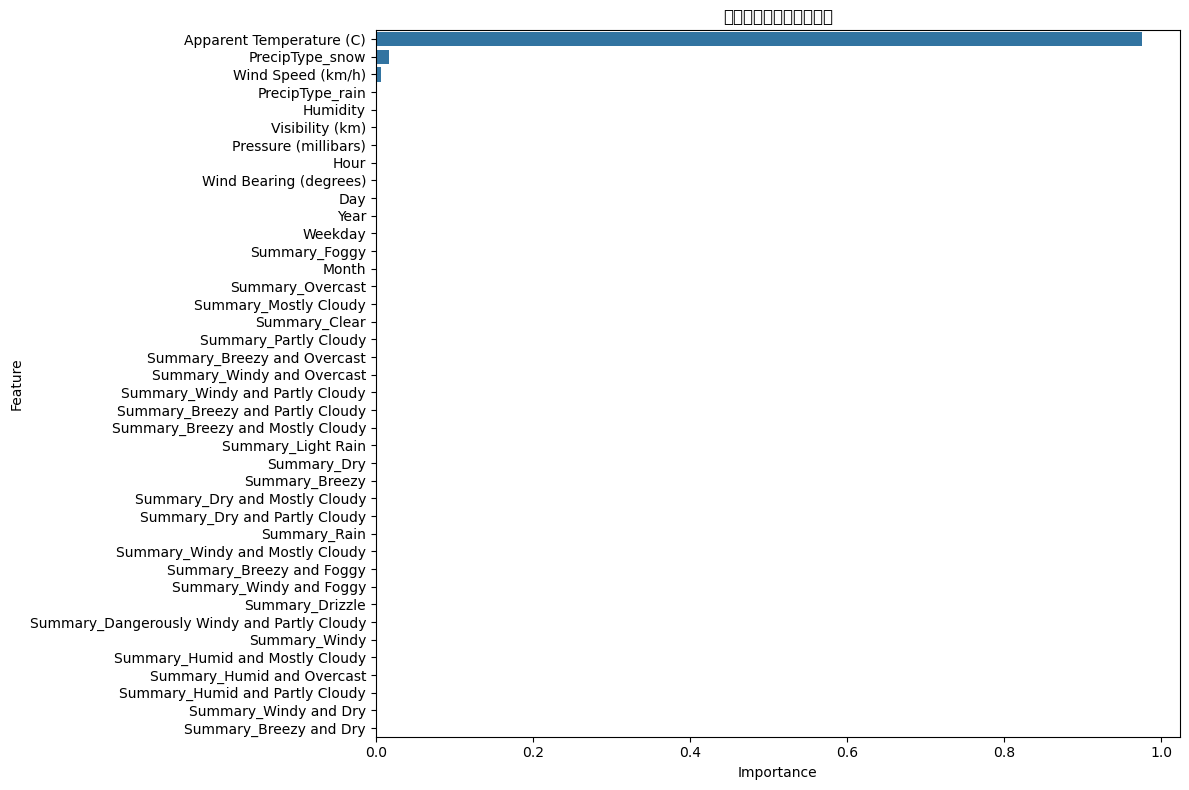

In [3]:
# 导入必要的库
from sklearn.ensemble import RandomForestRegressor


# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 训练模型
rf_model.fit(X_train, y_train)

# 对测试集进行预测
y_pred_rf = rf_model.predict(X_test)

# 评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} 模型评估结果：')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R² Score: {r2:.4f}\n')

# 评估随机森林模型
evaluate_model(y_test, y_pred_rf, '随机森林回归')

import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征重要性
importances = rf_model.feature_importances_

# 创建特征重要性数据框
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# 按重要性排序
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('特征重要性（随机森林）')
plt.tight_layout()
plt.show()



R²得分为1.0，非常不寻常，通常情况下，这可能是由于数据泄露或模型过拟合等问题引起的。

需要注意的是，Apparent Temperature (C)（体感温度）与Temperature (C)通常高度相关，可能导致模型几乎完美地预测。

### 2.2 检查特征与目标变量的相关性
让我们计算Apparent Temperature (C)与Temperature (C)之间的相关系数：

In [4]:
# 计算相关系数
correlation = data['Temperature (C)'].corr(data['Apparent Temperature (C)'])
print(f"Temperature 与 Apparent Temperature 的相关系数: {correlation}")


Temperature 与 Apparent Temperature 的相关系数: 0.9926254234649946


相关系数接近于1，说明这两个变量几乎是线性相关的。
在这种情况下，模型可以轻松地利用Apparent Temperature (C)来预测Temperature (C)，导致过拟合。
由于Apparent Temperature (C)与Temperature (C)高度相关，建议从特征矩阵X中移除该特征。

In [17]:
# 6. 定义特征矩阵 X，移除 'Temperature (C)' 和 'Apparent Temperature (C)'
X = data.drop(['Temperature (C)', 'Apparent Temperature (C)'], axis=1)

# 确认特征移除是否成功
print("\n特征列表（移除 'Temperature (C)' 和 'Apparent Temperature (C)' 后）：")
print(X.columns.tolist())


特征列表（移除 'Temperature (C)' 和 'Apparent Temperature (C)' 后）：
['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Summary_Breezy', 'Summary_Breezy and Dry', 'Summary_Breezy and Foggy', 'Summary_Breezy and Mostly Cloudy', 'Summary_Breezy and Overcast', 'Summary_Breezy and Partly Cloudy', 'Summary_Clear', 'Summary_Dangerously Windy and Partly Cloudy', 'Summary_Drizzle', 'Summary_Dry', 'Summary_Dry and Mostly Cloudy', 'Summary_Dry and Partly Cloudy', 'Summary_Foggy', 'Summary_Humid and Mostly Cloudy', 'Summary_Humid and Overcast', 'Summary_Humid and Partly Cloudy', 'Summary_Light Rain', 'Summary_Mostly Cloudy', 'Summary_Overcast', 'Summary_Partly Cloudy', 'Summary_Rain', 'Summary_Windy', 'Summary_Windy and Dry', 'Summary_Windy and Foggy', 'Summary_Windy and Mostly Cloudy', 'Summary_Windy and Overcast', 'Summary_Windy and Partly Cloudy', 'PrecipType_rain', 'PrecipType_snow']


随机森林回归（移除高相关特征后） 模型评估结果：
MSE: 2.6677
RMSE: 1.6333
MAE: 1.1897
R² Score: 0.9707



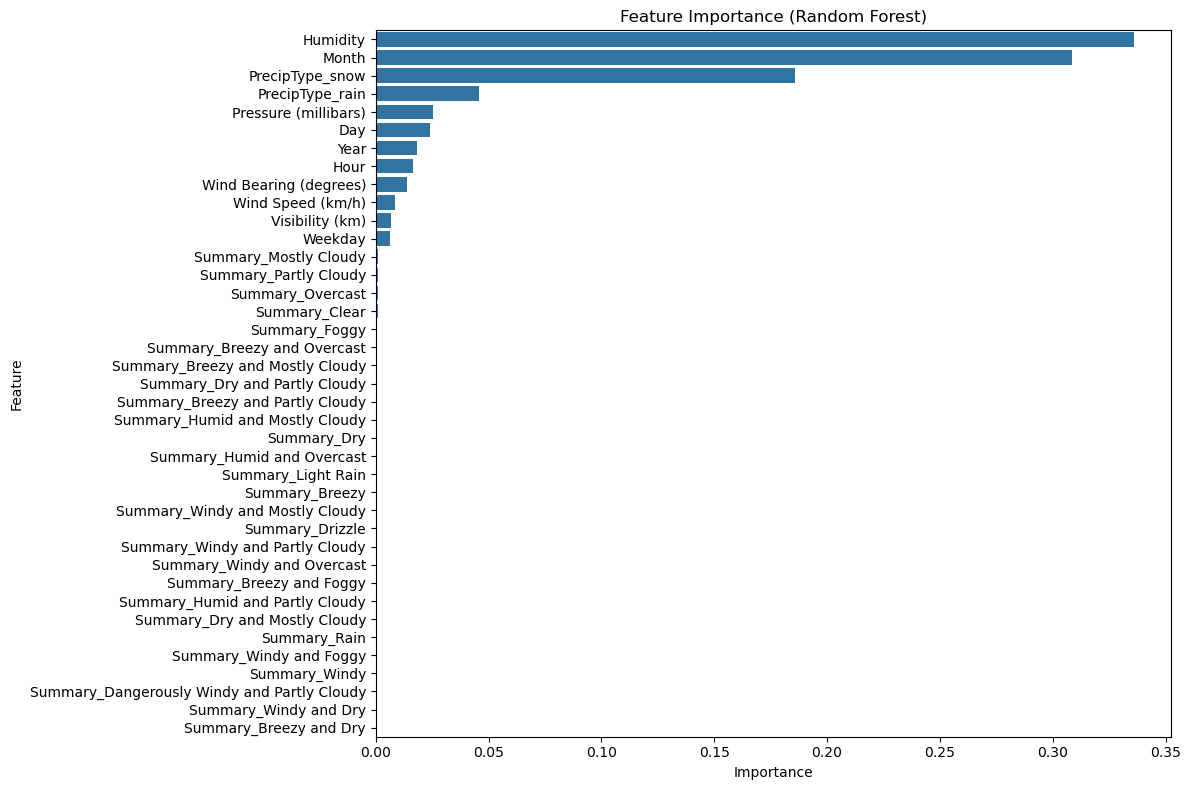

In [19]:
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 5. 定义目标变量 y
y = data['Temperature (C)']


# 7. 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 8. 特征缩放
scaler = StandardScaler()
numeric_features = ['Humidity', 'Wind Speed (km/h)',
                    'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
                    'Year', 'Month', 'Day', 'Hour', 'Weekday']

# 仅对数值型特征进行缩放
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 9. 训练随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 10. 对测试集进行预测
y_pred_rf = rf_model.predict(X_test)

# 11. 评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} 模型评估结果：')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R² Score: {r2:.4f}\n')

# 12. 评估随机森林模型
evaluate_model(y_test, y_pred_rf, '随机森林回归（移除高相关特征后）')

# 13. 特征重要性分析
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()




随机森林回归模型在移除高度相关特征（Apparent Temperature (C)）后，仍然显示出非常高的性能（R² Score: 0.9707）。

后续还需要通过交叉验证的方式来增强模型的泛化能力

### 2.3 使用交叉验证

使用交叉验证评估模型的性能，以确保模型的稳定性和泛化能力。


In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5, scoring="r2")
print(f"交叉验证 R² scores: {scores}")
print(f"平均 R²: {scores.mean():.4f}")

交叉验证 R² scores: [0.86640369 0.88049583 0.89717949 0.8592042  0.86954611]
平均 R²: 0.8746


随机森林回归模型在移除高度相关特征（Apparent Temperature (C)）后，仍然显示出非常高的性能（R² Score: 0.9707）。

在移除高度相关特征（Apparent Temperature (C)）后，再使用之前的线性回归模型进行对比。

In [22]:

# 对训练集进行拟合和转换
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# 对测试集进行转换
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 初始化线性回归模型
lr_model = LinearRegression()

# 训练模型
lr_model.fit(X_train, y_train)

# 对测试集进行预测
y_pred_lr = lr_model.predict(X_test)

# 定义评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} （移除Apparent Temperature (C)之后）模型评估结果：')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R² Score: {r2:.4f}\n')

# 评估线性回归模型
evaluate_model(y_test, y_pred_lr, '线性回归')


# 获取特征名称
feature_names = X_train.columns

# 获取模型系数
coefficients = lr_model.coef_

# 创建系数数据框
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# 按系数大小排序
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# 输出系数数据框
print(coeff_df)



线性回归 （移除Apparent Temperature (C)之后）模型评估结果：
MSE: 34.3205
RMSE: 5.8584
MAE: 4.7881
R² Score: 0.6231

                                        Feature   Coefficient
33                      Summary_Windy and Foggy  1.171861e+01
24                   Summary_Humid and Overcast  9.566806e+00
23              Summary_Humid and Mostly Cloudy  9.091295e+00
25              Summary_Humid and Partly Cloudy  8.648518e+00
37                              PrecipType_rain  6.050162e+00
12                     Summary_Breezy and Foggy  4.073170e+00
19                                  Summary_Dry  1.267394e+00
6                                         Month  1.069161e+00
3                               Visibility (km)  7.485661e-01
2                        Wind Bearing (degrees)  2.403551e-01
5                                          Year  1.110303e-01
7                                           Day  6.250611e-02
9                                       Weekday  6.511816e-04
11                       Summary_

将四种模型对比在一起看。形成如下图表

                                                        MSE    RMSE     MAE  \
Model Name                                                                    
Linear Regression (Remove Apparent Temperature ...  34.3205  5.8584  4.7881   
Random Forest Regression (Remove Highly Correla...   2.6677  1.6333  1.1897   
Random Forest Regression (Include Apparent Temp...   0.0024  0.0494  0.0136   
Linear Regression (Include Apparent Temperature...   0.8961  0.9466  0.7406   

                                                    R² Score  
Model Name                                                    
Linear Regression (Remove Apparent Temperature ...    0.6231  
Random Forest Regression (Remove Highly Correla...    0.9707  
Random Forest Regression (Include Apparent Temp...    1.0000  
Linear Regression (Include Apparent Temperature...    0.9902  


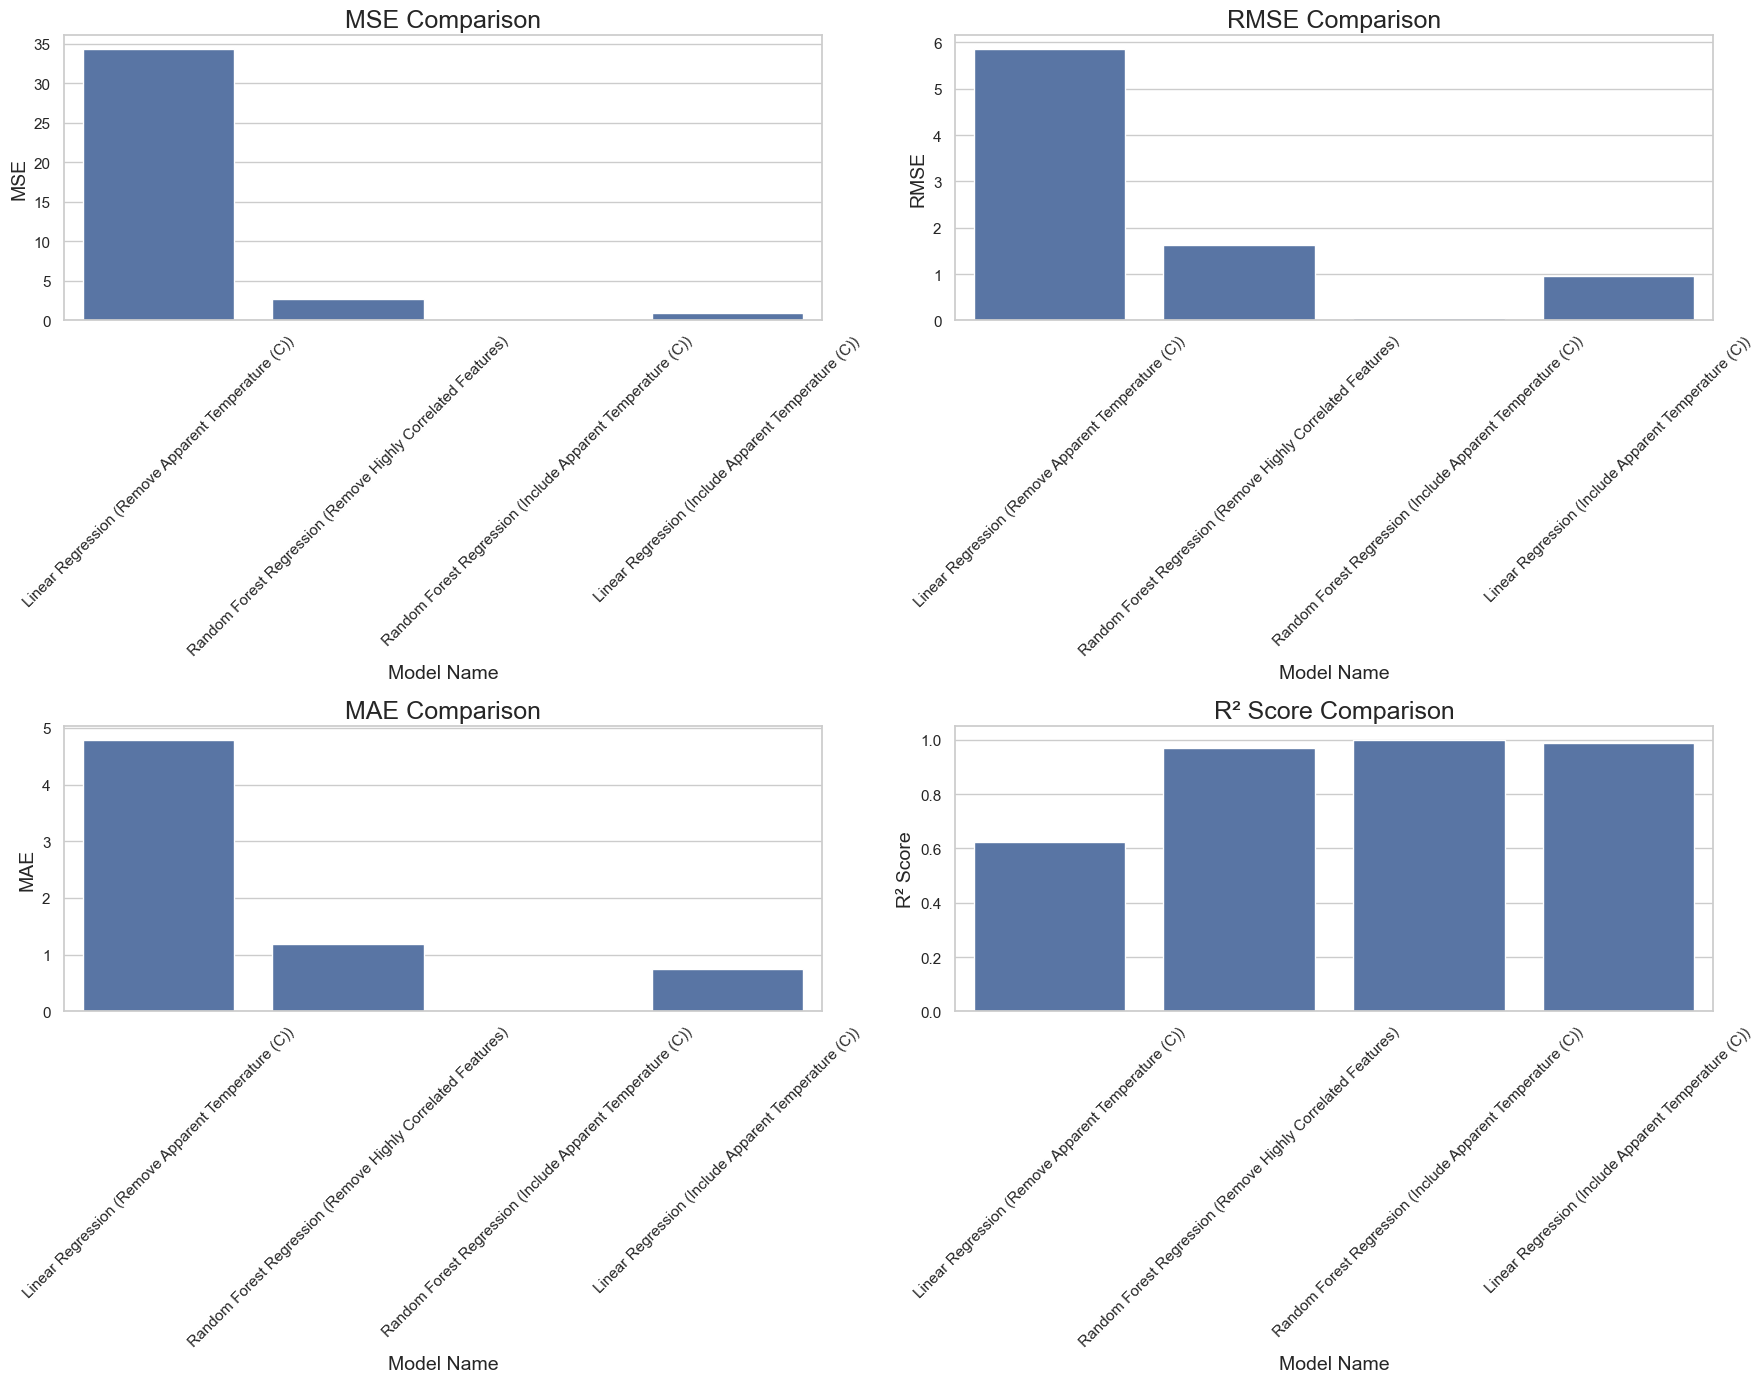

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel


evaluation_data = {
    'Model Name': [
        'Linear Regression (Remove Apparent Temperature (C))',
        'Random Forest Regression (Remove Highly Correlated Features)',
        'Random Forest Regression (Include Apparent Temperature (C))',
        'Linear Regression (Include Apparent Temperature (C))'
    ],
    'MSE': [34.3205, 2.6677, 0.0024, 0.8961],
    'RMSE': [5.8584, 1.6333, 0.0494, 0.9466],
    'MAE': [4.7881, 1.1897, 0.0136, 0.7406],
    'R² Score': [0.6231, 0.9707, 1.0000, 0.9902]
}

# Create DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Set Model Name as index
evaluation_df.set_index('Model Name', inplace=True)

# Display the table
print(evaluation_df)

# Set Seaborn plot style
sns.set(style="whitegrid")

# Create four subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))  # Increased figure size for better readability
axes = axes.flatten()

# Define metrics to plot
metrics = ['MSE', 'RMSE', 'MAE', 'R² Score']

for i, metric in enumerate(metrics):
    sns.barplot(
        x=evaluation_df.index,
        y=evaluation_df[metric],
        ax=axes[i]
        # palette='Set2'  # Removed to prevent FutureWarning
    )
    axes[i].set_title(f'{metric} Comparison', fontsize=18)
    axes[i].set_ylabel(metric, fontsize=14)
    axes[i].set_xlabel('Model Name', fontsize=14)
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels to prevent overlap

plt.tight_layout()
plt.show()


# 二、已知多变量对离散单变量的预测

**目标变量**: Summary(天气摘要)Summary 是一个描述天气状况的分类变量，因此我们可以将其视为**多分类问题**。

模型准确率：0.6936

分类报告：
                          precision    recall  f1-score   support

                  Breezy       1.00      0.44      0.62         9
          Breezy and Dry       0.00      0.00      0.00         1
        Breezy and Foggy       0.75      1.00      0.86         6
Breezy and Mostly Cloudy       0.55      0.53      0.54       116
     Breezy and Overcast       0.62      0.78      0.69        94
Breezy and Partly Cloudy       0.71      0.64      0.67        83
                   Clear       0.73      0.52      0.61      2162
                 Drizzle       1.00      0.57      0.73         7
                     Dry       1.00      0.29      0.44         7
   Dry and Mostly Cloudy       0.00      0.00      0.00         4
   Dry and Partly Cloudy       0.86      0.35      0.50        17
                   Foggy       1.00      1.00      1.00      1396
 Humid and Mostly Cloudy       0.00      0.00      0.00         4
      Humid and Overcast       0.00      0.00      0.00

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


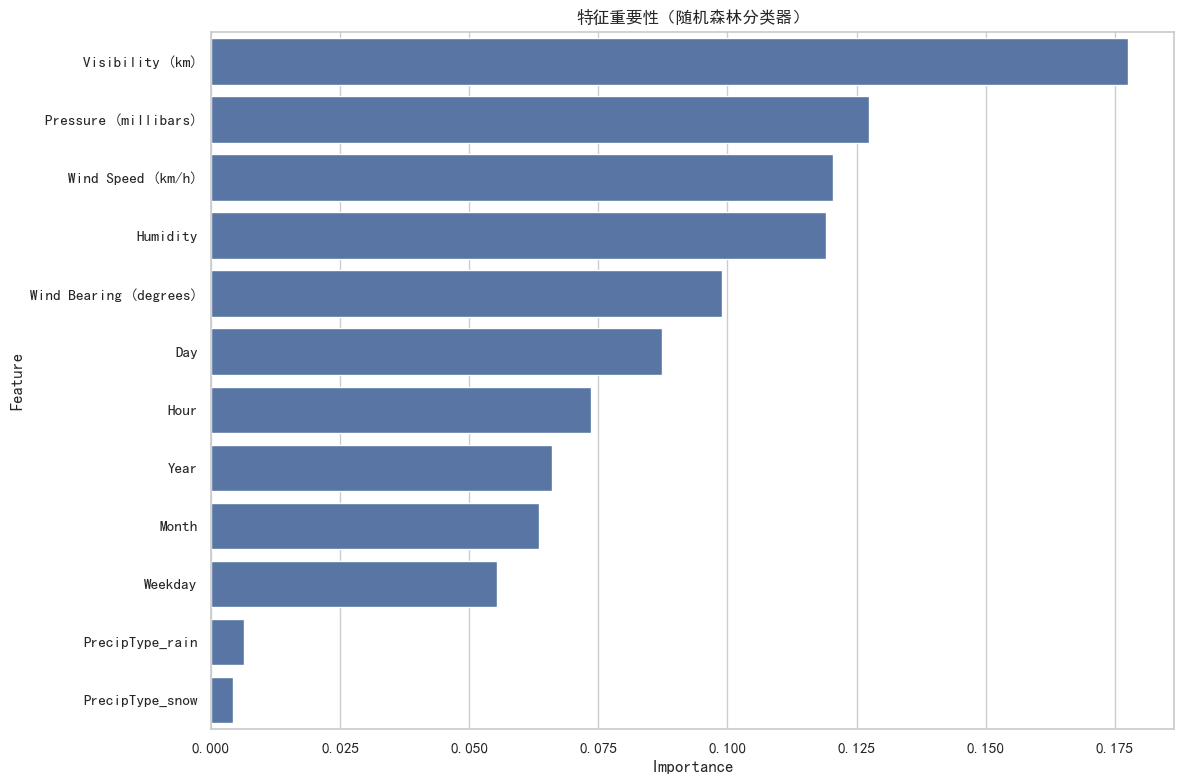

In [45]:
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 加载数据
data = pd.read_csv('weatherHistory.csv')

# 2. 数据预处理
# 转换日期时间格式
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

# 提取时间特征
data['Year'] = data['Formatted Date'].dt.year
data['Month'] = data['Formatted Date'].dt.month
data['Day'] = data['Formatted Date'].dt.day
data['Hour'] = data['Formatted Date'].dt.hour
data['Weekday'] = data['Formatted Date'].dt.weekday

# 删除原始日期列和 'Daily Summary'
data = data.drop(['Formatted Date', 'Daily Summary'], axis=1)

# 处理目标变量 'Summary'
label_encoder = LabelEncoder()
data['Summary_encoded'] = label_encoder.fit_transform(data['Summary'])

# 处理 'Precip Type' 的缺失值
data['Precip Type'] = data['Precip Type'].fillna('unknown')

# 独热编码 'Precip Type'
data = pd.get_dummies(data, columns=['Precip Type'], prefix='PrecipType')

# 删除高度相关的特征，避免数据泄露
data = data.drop(['Temperature (C)', 'Apparent Temperature (C)'], axis=1)

# 删除原始的 'Summary' 列
data = data.drop(['Summary'], axis=1)

# 3. 数据集划分
X = data.drop(['Summary_encoded'], axis=1)
y = data['Summary_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 4. 特征缩放
numeric_features = ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
                    'Visibility (km)', 'Pressure (millibars)', 'Year', 'Month',
                    'Day', 'Hour', 'Weekday']

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 5. 模型训练
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# 6. 模型评估
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'模型准确率：{accuracy:.4f}')

print("\n分类报告：")
# 修改部分：获取实际存在的标签和对应的类别名称
import numpy as np

# 获取预测和真实值中的所有标签
labels = np.unique(np.concatenate((y_test, y_pred)))
target_names = label_encoder.inverse_transform(labels)

# 生成分类报告
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

# 7. 特征重要性分析
importances = rf_classifier.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('特征重要性（随机森林分类器）')
plt.tight_layout()
plt.show()



模型准确率只有0.6936。

因而需要通过**超参数**优化区进行调优，超参数则是在算法运行之前手动设置的参数，用于控制模型的行为和性能。

这些超参数的选择会影响到模型的训练速度、收敛性、容量和泛化能力等方面。

例如，学习率、迭代次数、正则化参数、隐藏层的神经元数量等都是常见的超参数。

超参数的选择通常是一个试错的过程，需要根据经验和领域知识进行调整。


In [36]:
# 8. 超参数调优
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print(f'最佳参数：{grid_search.best_params_}')

best_rf_classifier = grid_search.best_estimator_
y_pred_best = best_rf_classifier.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'优化后模型准确率：{accuracy_best:.4f}')

print("\n优化后模型的分类报告：")
# 修改部分：获取实际存在的标签和对应的类别名称
labels_best = np.unique(np.concatenate((y_test, y_pred_best)))
target_names_best = label_encoder.inverse_transform(labels_best)

# 生成分类报告
print(classification_report(y_test, y_pred_best, labels=labels_best, target_names=target_names_best))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


最佳参数：{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
优化后模型准确率：0.7138

优化后模型的分类报告：
                          precision    recall  f1-score   support

                  Breezy       1.00      0.56      0.71         9
          Breezy and Dry       0.00      0.00      0.00         1
        Breezy and Foggy       0.86      1.00      0.92         6
Breezy and Mostly Cloudy       0.53      0.47      0.50       116
     Breezy and Overcast       0.63      0.80      0.70        94
Breezy and Partly Cloudy       0.63      0.63      0.63        83
                   Clear       0.74      0.57      0.64      2162
                 Drizzle       0.80      0.57      0.67         7
                     Dry       1.00      0.29      0.44         7
   Dry and Mostly Cloudy       0.00      0.00      0.00         4
   Dry and Partly Cloudy       0.80      0.47      0.59        17
                   Foggy       1.00      1.00      1.00      1396

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


初始模型准确率：0.6936

优化后模型准确率：0.7138

模型的整体准确率从 69.36% 提升到了 71.38%，这表明经过超参数调优后，模型的性能有所提升。

**少数类别**的性能

对于一些少数类别，如 'Breezy and Dry'、'Dry and Mostly Cloudy'、'Humid and Mostly Cloudy' 等，precision 和 recall 都为 0，这意味着模型无法正确预测这些类别。

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


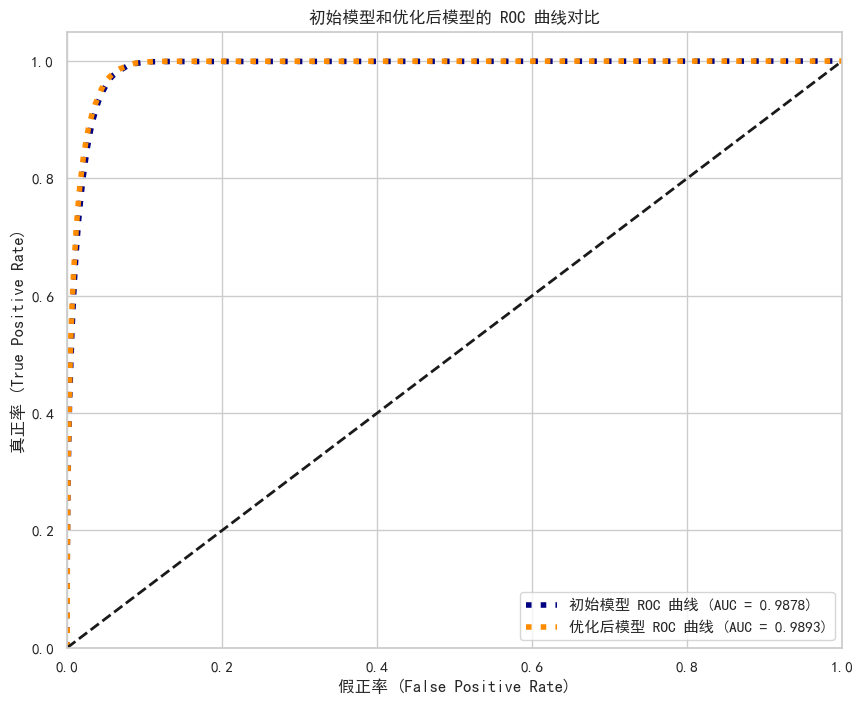

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 初始模型
classes = rf_classifier.classes_
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = rf_classifier.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 优化后模型
classes_best = best_rf_classifier.classes_
n_classes_best = len(classes_best)
y_test_binarized_best = label_binarize(y_test, classes=classes_best)
y_score_best = best_rf_classifier.predict_proba(X_test)

fpr_best = dict()
tpr_best = dict()
roc_auc_best = dict()

for i in range(n_classes_best):
    fpr_best[i], tpr_best[i], _ = roc_curve(y_test_binarized_best[:, i], y_score_best[:, i])
    roc_auc_best[i] = auc(fpr_best[i], tpr_best[i])

fpr_best["micro"], tpr_best["micro"], _ = roc_curve(y_test_binarized_best.ravel(), y_score_best.ravel())
roc_auc_best["micro"] = auc(fpr_best["micro"], tpr_best["micro"])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='初始模型 ROC 曲线 (AUC = {0:0.4f})'.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr_best["micro"], tpr_best["micro"],
         label='优化后模型 ROC 曲线 (AUC = {0:0.4f})'.format(roc_auc_best["micro"]),
         color='darkorange', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('初始模型和优化后模型的 ROC 曲线对比')
plt.legend(loc="lower right")
plt.show()


在进行超参数优化之后，可以注意到模型的能力有所提升，从优化前的0.9878提升到了0.9893。


## 2.1. **准确度（Accuracy）公式**：

准确度衡量模型预测正确的比例，计算公式为：

\[
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\]

- **TP**（True Positive，真正类）：预测为正类且实际为正类的数量。
- **TN**（True Negative，真负类）：预测为负类且实际为负类的数量。
- **FP**（False Positive，假正类）：预测为正类但实际为负类的数量。
- **FN**（False Negative，假负类）：预测为负类但实际为正类的数量。


**注意**：准确度并不能总是反映模型的整体表现，特别是在类别不平衡的数据集中。


## 2.2. **ROC-AUC 曲线**：
ROC 曲线（Receiver Operating Characteristic Curve）表示在不同的分类阈值下，模型的 **假正率**（FPR）和 **真正率**（TPR）之间的关系。

- **TPR（True Positive Rate，真正率）**，即 **召回率（Recall）**，计算公式为：

\[
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\]

- **FPR（False Positive Rate，假正率）**，计算公式为：

\[
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\]

- **AUC（Area Under Curve）**：即 ROC 曲线下的面积，表示模型区分正负类能力的一个综合指标。AUC 值越接近 1，模型的区分能力越强；若 AUC=0.5，则模型的表现与随机猜测没有区别。

## 2.3. **多分类问题下 TPR 和 FPR 的计算**：
对于多分类问题，通常使用 **"一对多"（One-vs-Rest, OvR）** 的方法来计算 TPR 和 FPR。

## **真正率 (TPR) 公式**：
每个类别的真正率（Recall）是在将该类别作为正类时的召回率，公式为：

\[
\text{TPR}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i}
\]

其中：
- **TP** 是第 \(i\) 类的真正类（预测为第 \(i\) 类且实际为第 \(i\) 类的样本数）。
- **FN** 是第 \(i\) 类的假负类（实际为第 \(i\) 类但预测为其他类的样本数）。

### **假正率 (FPR) 公式**：
假正率是将其他所有类别作为负类时的错误率，公式为：

\[
\text{FPR}_i = \frac{\text{FP}_i}{\text{FP}_i + \text{TN}_i}
\]

其中：
- **FP** 是第 \(i\) 类的假正类（实际为其他类别但预测为第 \(i\) 类的样本数）。
- **TN** 是第 \(i\) 类的真负类（实际为其他类别且预测也为其他类别的样本数）。

## 2.4. **多分类问题的 ROC-AUC 计算**：

通常有两种方法来计算多分类问题的 AUC 值：

### **(1) 宏平均（Macro-Averaging）**：
对每个类别的 AUC 值进行简单平均：

\[
\text{AUC}_{macro} = \frac{1}{n} \sum_{i=1}^{n} \text{AUC}_i
\]

### **(2) 微平均（Micro-Averaging）**：
将每个类别的 TP、FP、TN 和 FN 累加起来，计算整体的 TPR 和 FPR，绘制整体的 ROC 曲线并计算 AUC 值：

\[
\text{AUC}_{micro} = \text{ROC曲线下的面积 (基于所有类别的预测结果)}
\]


### **同样，ROC-AUC曲线也有一个严重的问题，精确率为 0 对 AUC 没有很大影响**